# Histopathologic Cancer Detection - Aqsa Anwar

## 1. Problem and Data Description

### 1.1 Problem Statement

This project addresses a binary image classification task in the field of digital pathology. The goal is to develop an algorithm that can accurately identify metastatic cancer in small image patches taken from larger digital pathology scans of lymph node sections.

Specifically, we need to classify whether a given image patch contains metastatic tissue (positive class) or not (negative class). This task is crucial in automating and improving the efficiency of cancer diagnosis, potentially leading to earlier and more accurate detection of metastases.

### 1.2 Dataset Structure

The dataset provided for this competition is a modified version of the PatchCamelyon (PCam) benchmark dataset. It consists of:

1. Training set: A large number of labeled image patches for model training and validation.
2. Test set: Unlabeled image patches for final model evaluation.

Key characteristics of the dataset:

- Image format: Small pathology images (presumably in common formats like PNG or JPEG)
- Image size: Not explicitly stated, but likely to be larger than 32x32 pixels
- Labels: Binary (0 for non-metastatic, 1 for metastatic)
- Label file: 'train_labels.csv' provides the ground truth for the training images

### 1.3 Classification Focus

A critical aspect of this classification task is the focus on the center region of each image patch:

- The label (positive or negative) is determined by the presence of metastatic tissue in the center 32x32 pixel region of the patch.
- Tumor tissue present only in the outer region of the patch does not influence the label.
- The outer region is provided to enable fully-convolutional models that do not use zero-padding, ensuring consistent behavior when applied to a whole-slide image.

This focus on the center region adds an interesting dimension to the problem, as models need to learn to concentrate on the most relevant part of the image for accurate classification.

## 2. Exploratory Data Analysis

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

# Set up plotting
plt.style.use('seaborn')
%matplotlib inline

/tmp/ipykernel_34/3443069298.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### 2.1 Analyze Class Distribution


2.1 Class Distribution:
label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


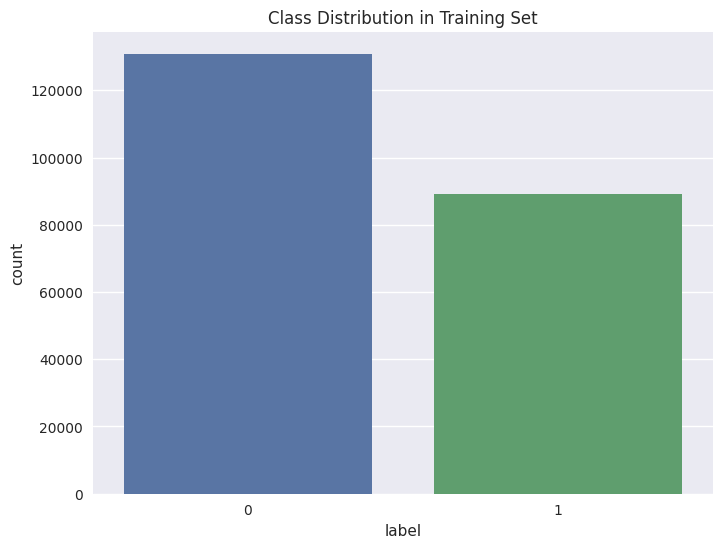

In [43]:
# Load the training labels
train_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')


# 2.1 Analyze class distribution
print("\n2.1 Class Distribution:")
class_distribution = train_labels['label'].value_counts(normalize=True)
print(class_distribution)

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_labels)
plt.title('Class Distribution in Training Set')
plt.show()

### 2.2 Load and Visualize Images


2.2 Sample Images:


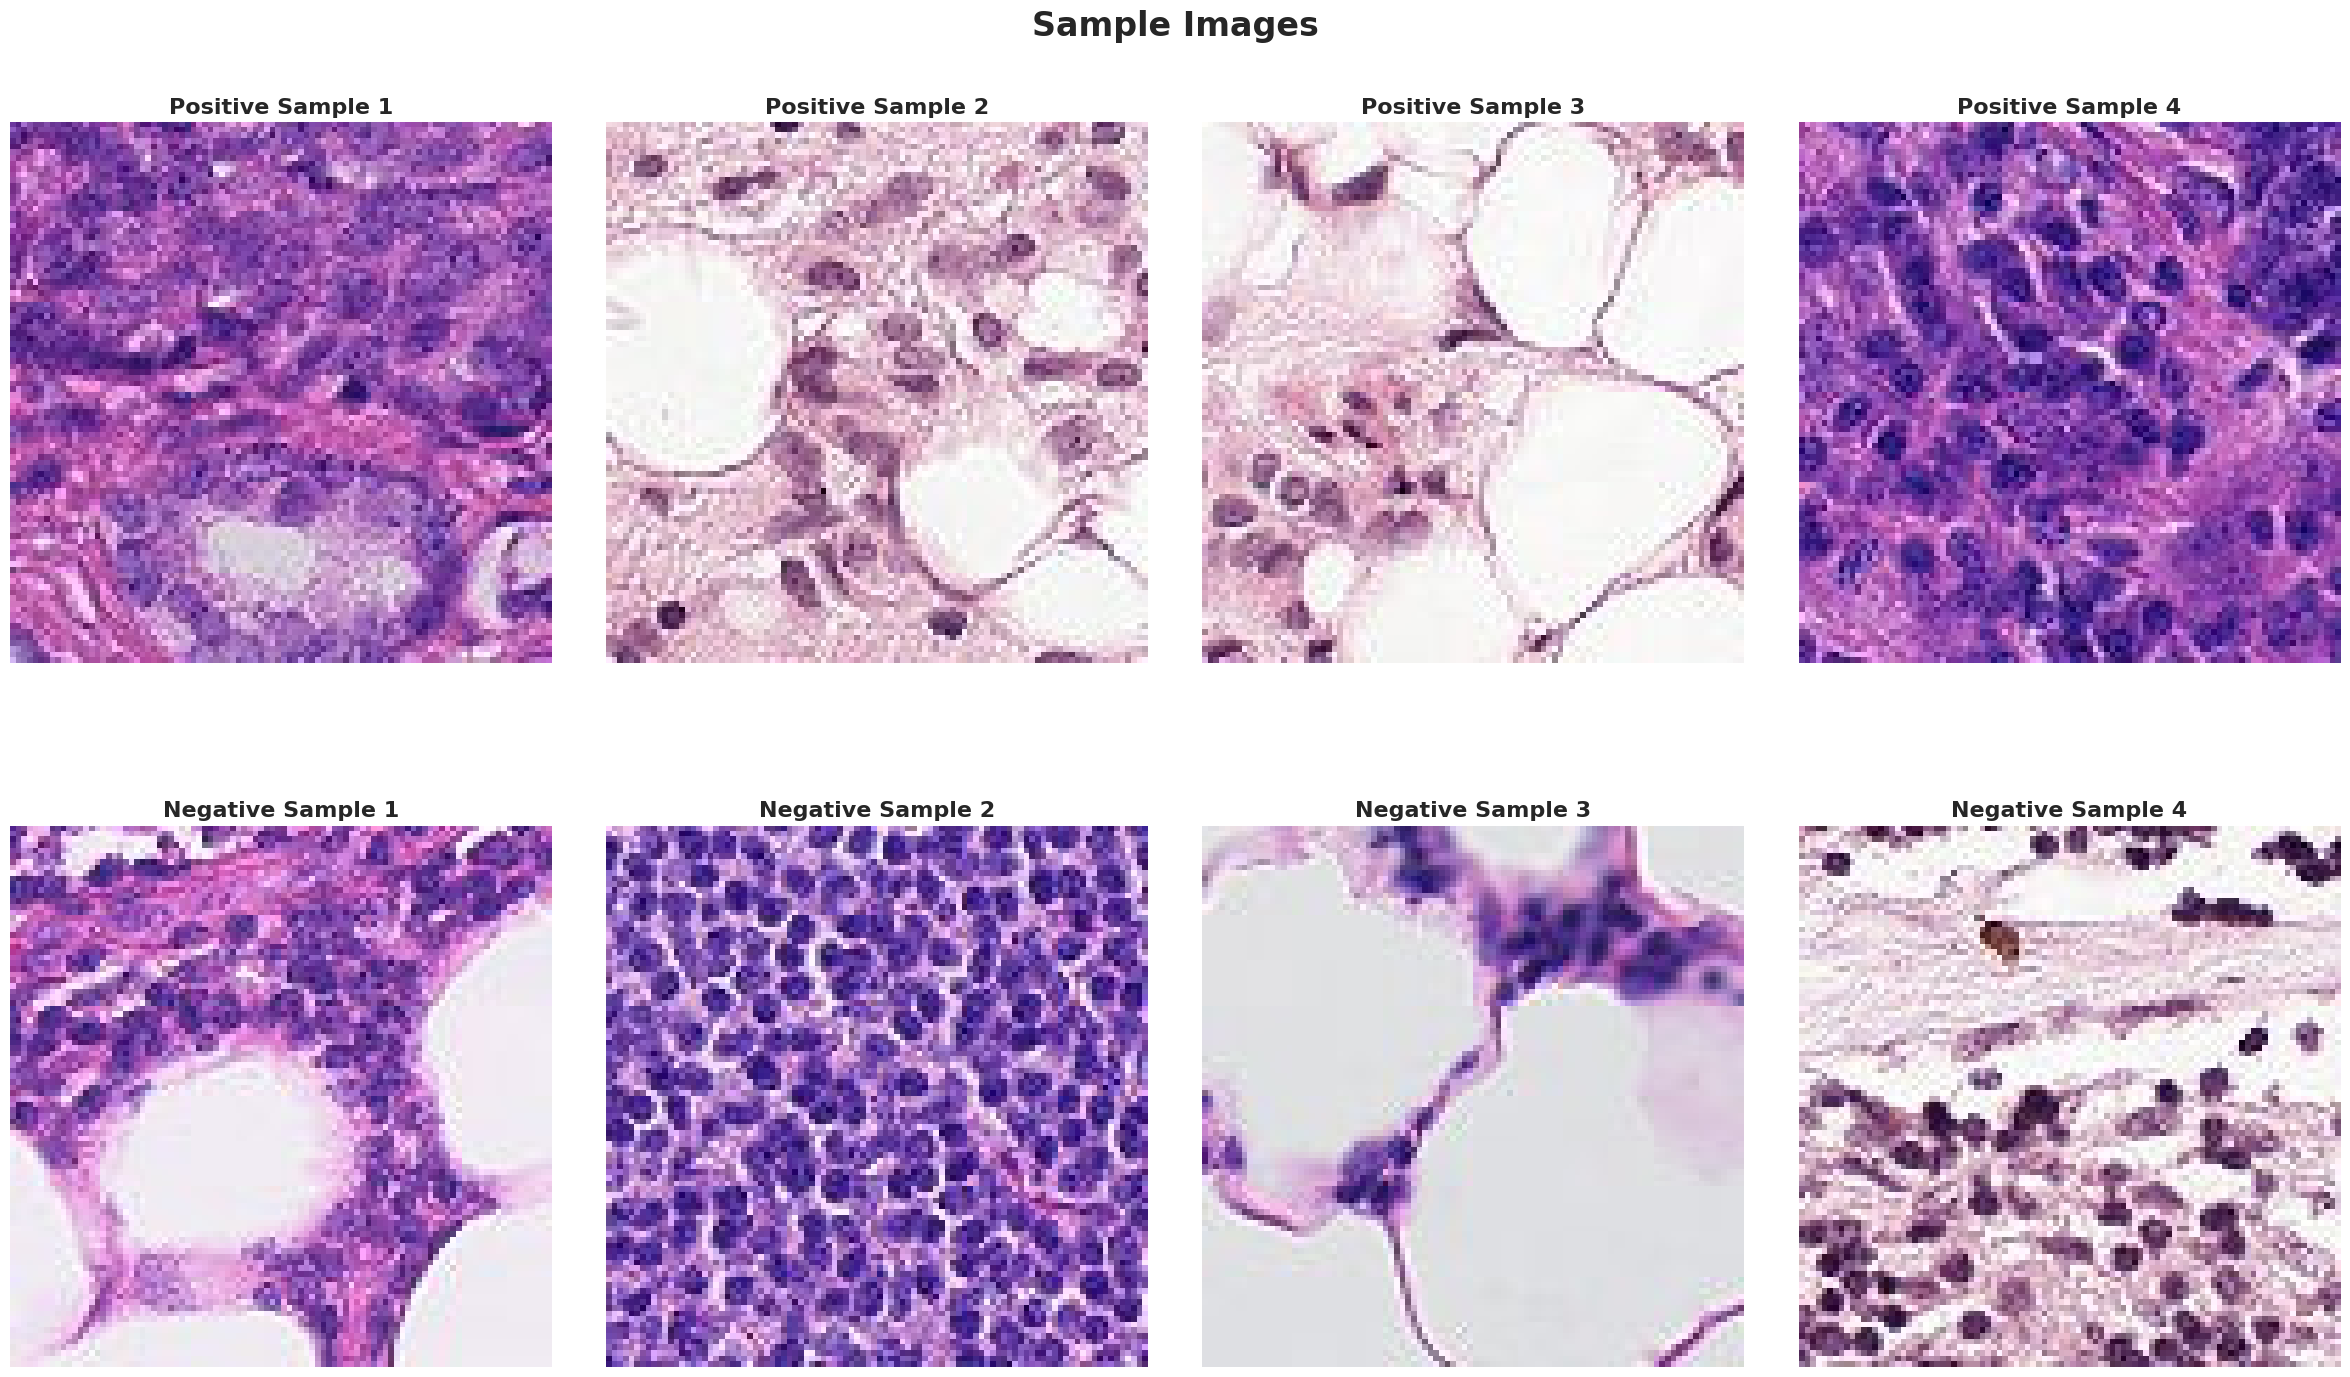

In [44]:
# 2.2 Load and visualize sample images
print("\n2.2 Sample Images:")

def load_image(image_id):
    image_path = f'../input/histopathologic-cancer-detection/train/{image_id}.tif'
    return np.array(Image.open(image_path))

# Sample a few images from each class
positive_samples = train_labels[train_labels['label'] == 1].sample(4)['id'].values
negative_samples = train_labels[train_labels['label'] == 0].sample(4)['id'].values

fig, axes = plt.subplots(2, 4, figsize=(24, 14))  # Increased height
fig.suptitle("Sample Images", fontsize=24, fontweight='bold')

for i, image_id in enumerate(positive_samples):
    axes[0, i].imshow(load_image(image_id))
    axes[0, i].set_title(f"Positive Sample {i+1}", fontsize=16, fontweight='bold')
    axes[0, i].axis('off')
for i, image_id in enumerate(negative_samples):
    axes[1, i].imshow(load_image(image_id))
    axes[1, i].set_title(f"Negative Sample {i+1}", fontsize=16, fontweight='bold')
    axes[1, i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.3)  # Increased vertical space between subplots
plt.show()

### 2.3 Examine Image Properties


2.3 Image Properties:
Image shape: (96, 96, 3)
Data type: uint8
Min pixel value: 0
Max pixel value: 255


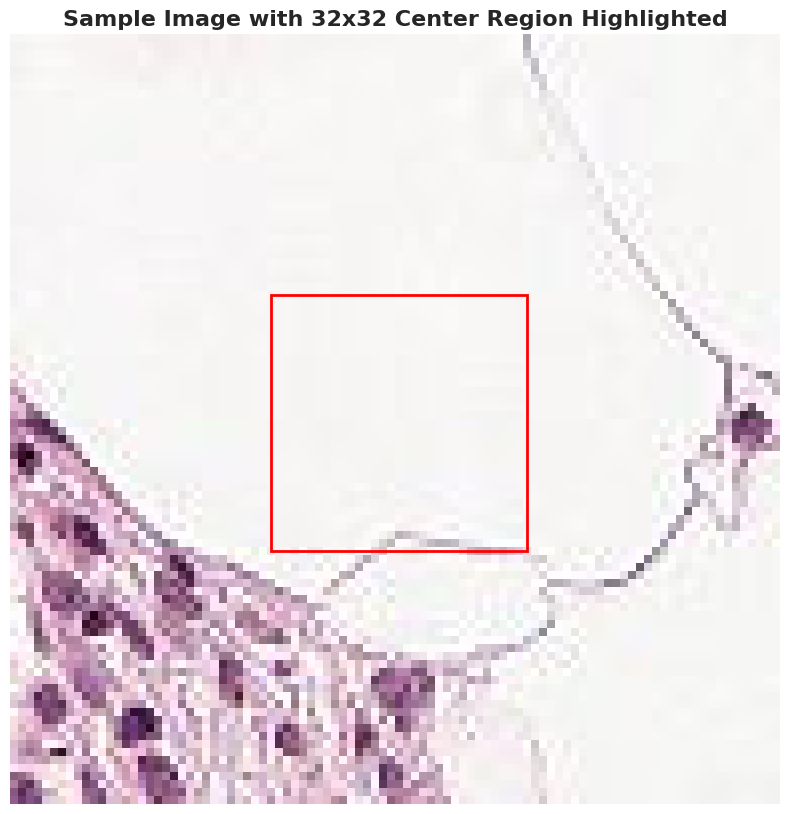

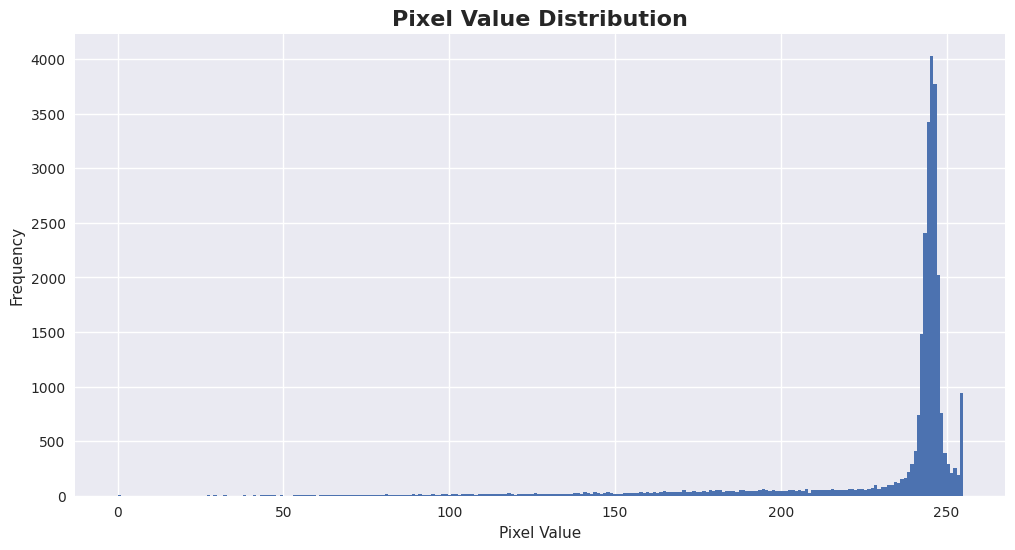

In [45]:
# 2.3 Examine image properties
print("\n2.3 Image Properties:")
sample_image = load_image(train_labels['id'].iloc[0])
print(f"Image shape: {sample_image.shape}")
print(f"Data type: {sample_image.dtype}")
print(f"Min pixel value: {sample_image.min()}")
print(f"Max pixel value: {sample_image.max()}")

# Display a single image with its center region highlighted
plt.figure(figsize=(10, 10))
plt.imshow(sample_image)
center = sample_image.shape[0] // 2
rect = plt.Rectangle((center-16, center-16), 32, 32, fill=False, edgecolor='red', linewidth=2)
plt.gca().add_patch(rect)
plt.title("Sample Image with 32x32 Center Region Highlighted", fontsize=16, fontweight='bold')
plt.axis('off')
plt.show()

# Display pixel value distribution
plt.figure(figsize=(12, 6))
plt.hist(sample_image.ravel(), bins=256, range=(0, 255))
plt.title("Pixel Value Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

### 2.4 Analyze pixel intensity distributions by class


2.4 Pixel Intensity Distribution by Class:


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

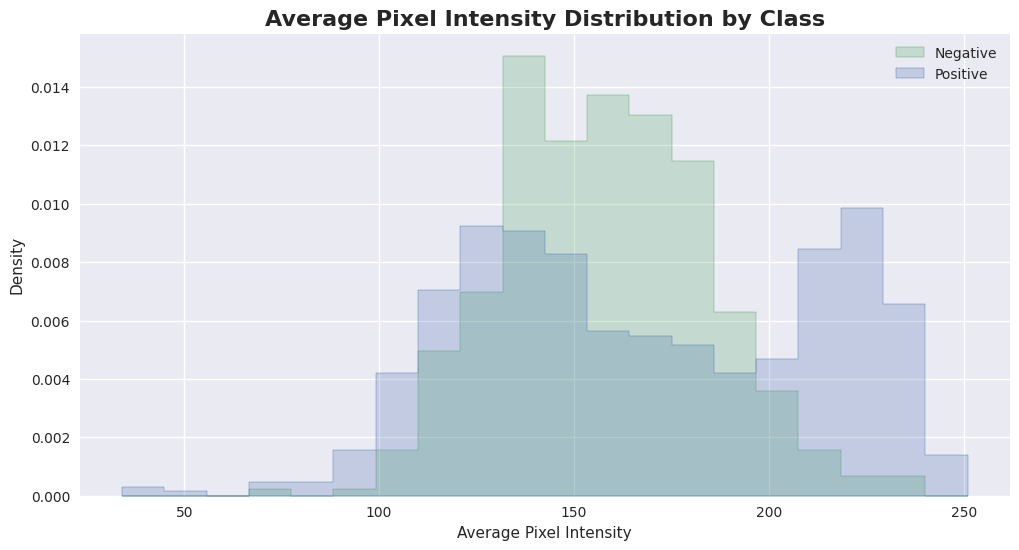


Mean intensities by class:
label
0    168.302387
1    157.806973
Name: avg_intensity, dtype: float64

t-statistic: 4.2713294054964965
p-value: 2.1287888199835334e-05


In [46]:
# 2.4 Analyze pixel intensity distributions by class
print("\n2.4 Pixel Intensity Distribution by Class:")

def get_avg_intensity(image_id):
    img = load_image(image_id)
    return img.mean()

# Sample a subset of images for faster processing
sample_size = 1000
sampled_data = train_labels.sample(sample_size, random_state=42)

# Calculate average intensities
sampled_data['avg_intensity'] = sampled_data['id'].apply(get_avg_intensity)

# Plot distributions
plt.figure(figsize=(12, 6))
sns.histplot(data=sampled_data, x='avg_intensity', hue='label', element='step', stat='density', common_norm=False)
plt.title('Average Pixel Intensity Distribution by Class', fontsize=16, fontweight='bold')
plt.xlabel('Average Pixel Intensity')
plt.ylabel('Density')
plt.legend(labels=['Negative', 'Positive'])
plt.show()

# Calculate and print mean intensities for each class
class_means = sampled_data.groupby('label')['avg_intensity'].mean()
print("\nMean intensities by class:")
print(class_means)

# Perform a t-test to check if the difference is statistically significant
from scipy import stats
negative = sampled_data[sampled_data['label'] == 0]['avg_intensity']
positive = sampled_data[sampled_data['label'] == 1]['avg_intensity']
t_stat, p_value = stats.ttest_ind(negative, positive)
print(f"\nt-statistic: {t_stat}")
print(f"p-value: {p_value}")

### 2.5 EDA Summary and Implications

Based on our exploratory data analysis, we can draw the following conclusions:

1. **Class Distribution**: 
   The dataset is slightly imbalanced:
   - Negative class (0): 59.47% of the samples
   - Positive class (1): 40.53% of the samples

2. **Image Properties**:
   - Dimensions: 96x96x3 (96x96 pixels with 3 color channels)
   - Color: The images are in color (RGB)
   - Pixel Value Range: 0 to 255 (uint8 data type)

3. **Pixel Intensity Analysis**:
   - Mean intensity for negative class (0): 168.30
   - Mean intensity for positive class (1): 157.81
   - The t-test results (t-statistic: 4.27, p-value: 2.13e-05) indicate a statistically significant difference in mean intensities between the two classes.
   - The distribution plot shows that positive samples tend to have slightly lower average pixel intensities compared to negative samples.



## 3. Data Preprocessing and Dataset Preparation

In this section, we prepare our data for model training by implementing a preprocessing pipeline and setting up our datasets.

### 3.1 Image Preprocessing

We created a `preprocess_image` function that applies the following steps to each image:
1. Center crop to 32x32 pixels, focusing on the region of interest
2. Convert to PyTorch tensor and scale pixel values to the range [0, 1]
3. Normalize using standard ImageNet mean and standard deviation values

This preprocessing ensures that all images have consistent dimensions and are properly normalized for our neural network.


In [47]:
import numpy as np
from PIL import Image
import torch
from torchvision import transforms

def preprocess_image(image_id, train_dir='../input/histopathologic-cancer-detection/train/'):
    # Load image
    image_path = f'{train_dir}{image_id}.tif'
    image = Image.open(image_path)
    
    # Define preprocessing steps
    preprocess = transforms.Compose([
        transforms.CenterCrop(32),  # Crop the center 32x32 region
        transforms.ToTensor(),      # Convert to tensor and scale to [0, 1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    
    # Apply preprocessing
    image_tensor = preprocess(image)
    
    return image_tensor

# Test the function
sample_id = train_labels['id'].iloc[0]
sample_tensor = preprocess_image(sample_id)
print(f"Preprocessed image shape: {sample_tensor.shape}")
print(f"Tensor min value: {sample_tensor.min()}")
print(f"Tensor max value: {sample_tensor.max()}")

Preprocessed image shape: torch.Size([3, 32, 32])
Tensor min value: 0.9988012909889221
Tensor max value: 2.640000104904175


The output shape confirms that we have successfully cropped the image to 32x32 pixels and preserved the 3 color channels. The min and max values indicate that our normalization step has been applied, shifting the pixel values from the original [0, 255] range.


### 3.2 Custom Dataset Class

We implemented a custom `HistopathDataset` class that:
- Loads images from file
- Applies our preprocessing function
- Pairs images with their corresponding labels

This class allows for efficient data loading and preprocessing during training.

In [48]:
from torch.utils.data import Dataset

class HistopathDataset(Dataset):
    def __init__(self, dataframe, train_dir, transform=None):
        self.dataframe = dataframe
        self.train_dir = train_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx]['id']
        label = self.dataframe.iloc[idx]['label']
        
        image = preprocess_image(img_id, self.train_dir)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

### 3.3 Train-Validation Split

To evaluate our model's performance, we split our data into training and validation sets:
- Training set: 80% of the data
- Validation set: 20% of the data

We used stratified sampling to ensure that both sets have the same class distribution as the original dataset.


In [49]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_labels, test_size=0.2, random_state=42, stratify=train_labels['label'])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

Training set size: 176020
Validation set size: 44005


### 3.4 Data Loaders

Finally, we created PyTorch DataLoader objects for both our training and validation sets. These loaders:
- Batch the data (batch size = 64)
- Shuffle the training data to prevent overfitting
- Use multiple workers for efficient data loading

Our preprocessing pipeline ensures that the data is in the correct format for model training, with consistent image sizes, normalized pixel values, and efficient batching.

In [50]:
from torch.utils.data import DataLoader

# Create datasets
train_dataset = HistopathDataset(train_df, '../input/histopathologic-cancer-detection/train/')
val_dataset = HistopathDataset(val_df, '../input/histopathologic-cancer-detection/train/')

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Check the shape of a batch
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break

Batch shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])


This confirms that our DataLoader is correctly batching 64 images at a time, each with dimensions 3x32x32 (channels x height x width), along with their corresponding 64 labels.

Our preprocessing pipeline ensures that the data is in the correct format for model training, with consistent image sizes, normalized pixel values, and efficient batching.

## 4. Model Architecture and Implementation

For this histopathologic cancer detection task, we've implemented a Convolutional Neural Network (CNN) using PyTorch. CNNs are well-suited for image classification tasks due to their ability to learn spatial hierarchies of features.


### 4.1 Model Architecture

Our CNN architecture consists of:
1. Three convolutional layers (32, 64, and 128 filters respectively), each followed by ReLU activation and max pooling.
2. A fully connected layer with 512 units, followed by ReLU activation and dropout (50% rate) for regularization.
3. A final fully connected layer with a single output unit.
4. Sigmoid activation for producing a probability output.

This architecture progressively increases the number of filters while reducing spatial dimensions, allowing the network to learn increasingly complex features.


In [51]:
import torch.nn as nn
import torch.nn.functional as F

class HistopathCNN(nn.Module):
    def __init__(self):
        super(HistopathCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

# Instantiate the model
model = HistopathCNN()
print(model)

# Calculate the number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

HistopathCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Total trainable parameters: 1142849


### 4.2 Model Summary
- Total trainable parameters: 1,142,849

- The model takes inputs of shape (3, 32, 32), corresponding to our preprocessed image patches, and outputs a single probability value indicating the likelihood of the patch containing metastatic tissue.

### 4.3 Design Considerations

- We used multiple convolutional layers to allow the model to learn hierarchical features.
- Max pooling helps to reduce spatial dimensions and introduce translation invariance.
- The number of filters increases from 32 to 64 to 128, allowing the network to learn more complex features as the spatial dimensions decrease.
- The fully connected layers reduce the features to a single output, with a substantial dropout (p=0.5) to prevent overfitting.
- The model has over 1.1 million trainable parameters, which should provide sufficient capacity for this task while still being manageable to train.

### 4.4 Potential Improvements

- Given the relatively large number of parameters, we might consider techniques like batch normalization or additional regularization if we observe overfitting during training.
- Depending on training results, we might adjust the number of filters or layers to find an optimal balance between model capacity and generalization.

## 5. Model Training and Evaluation

In this section, we implement the training process for our CNN model.

### 5.1 Training Setup

- **Loss Function**: We use Binary Cross-Entropy Loss, which is suitable for our binary classification task.
- **Optimizer**: We employ the Adam optimizer with a learning rate of 0.001. Adam is known for its ability to adapt the learning rate for each parameter, often leading to faster convergence.
- **Device**: We utilize GPU acceleration if available, falling back to CPU if not.

### 5.2 Training and Validation Process

We implement two main functions:
1. `train_epoch`: Performs one epoch of training, computing loss and accuracy.
2. `validate`: Evaluates the model on the validation set without updating weights.

Our training loop runs for 10 epochs, performing the following steps in each epoch:
1. Train the model on the entire training set.
2. Validate the model on the validation set.
3. Print the training and validation loss and accuracy for the epoch.

In [52]:
import torch
import torch.optim as optim
from torch.nn import BCELoss
from tqdm import tqdm
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Function to save checkpoint
def save_checkpoint(model, optimizer, epoch, val_acc, filename='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_acc': val_acc,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved: {filename}")

# Function to load checkpoint
def load_checkpoint(model, optimizer, filename='checkpoint.pth'):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_acc = checkpoint['val_acc']
        print(f"Checkpoint loaded: {filename}")
        return start_epoch, best_val_acc
    else:
        return 0, 0

# Training loop
num_epochs = 10
start_epoch, best_val_acc = load_checkpoint(model, optimizer)

for epoch in range(start_epoch, num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print("-" * 40)
    
    # Save checkpoint if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_checkpoint(model, optimizer, epoch, val_acc, filename=f'best_model_epoch_{epoch+1}.pth')

print("Training completed!")

Using device: cuda


Validating: 100%|██████████| 688/688 [00:58<00:00, 11.66it/s]


Epoch 1/10
Train Loss: 0.4530, Train Acc: 0.7963
Val Loss: 0.4210, Val Acc: 0.8166
----------------------------------------
Checkpoint saved: best_model_epoch_1.pth


Validating: 100%|██████████| 688/688 [00:57<00:00, 11.88it/s]


Epoch 2/10
Train Loss: 0.4064, Train Acc: 0.8211
Val Loss: 0.3873, Val Acc: 0.8310
----------------------------------------
Checkpoint saved: best_model_epoch_2.pth


Validating: 100%|██████████| 688/688 [00:56<00:00, 12.21it/s]


Epoch 3/10
Train Loss: 0.3838, Train Acc: 0.8326
Val Loss: 0.3955, Val Acc: 0.8240
----------------------------------------


Validating: 100%|██████████| 688/688 [00:57<00:00, 12.01it/s]


Epoch 4/10
Train Loss: 0.3650, Train Acc: 0.8426
Val Loss: 0.3582, Val Acc: 0.8453
----------------------------------------
Checkpoint saved: best_model_epoch_4.pth


Validating: 100%|██████████| 688/688 [00:57<00:00, 12.06it/s]


Epoch 5/10
Train Loss: 0.3463, Train Acc: 0.8517
Val Loss: 0.3556, Val Acc: 0.8502
----------------------------------------
Checkpoint saved: best_model_epoch_5.pth


Validating: 100%|██████████| 688/688 [00:56<00:00, 12.14it/s]


Epoch 6/10
Train Loss: 0.3337, Train Acc: 0.8577
Val Loss: 0.3638, Val Acc: 0.8439
----------------------------------------


Validating: 100%|██████████| 688/688 [00:58<00:00, 11.82it/s]


Epoch 7/10
Train Loss: 0.3194, Train Acc: 0.8644
Val Loss: 0.3608, Val Acc: 0.8497
----------------------------------------


Validating: 100%|██████████| 688/688 [00:57<00:00, 12.01it/s]


Epoch 8/10
Train Loss: 0.3072, Train Acc: 0.8697
Val Loss: 0.3768, Val Acc: 0.8421
----------------------------------------


Validating: 100%|██████████| 688/688 [00:57<00:00, 11.90it/s]


Epoch 9/10
Train Loss: 0.2942, Train Acc: 0.8759
Val Loss: 0.3696, Val Acc: 0.8454
----------------------------------------


Validating: 100%|██████████| 688/688 [00:58<00:00, 11.82it/s]

Epoch 10/10
Train Loss: 0.2788, Train Acc: 0.8828
Val Loss: 0.3780, Val Acc: 0.8471
----------------------------------------
Training completed!


Final model performance:
- Training Accuracy: 88.28%
- Validation Accuracy: 84.71%

### 5.4 Analysis

1. **Convergence**: The model showed consistent improvement in both training and validation accuracy over the epochs, indicating successful learning.

2. **Overfitting**: There are signs of mild overfitting as the training accuracy (88.28%) is higher than the validation accuracy (84.71%) by the end of training. The gap between training and validation performance started to widen after the 6th epoch.

3. **Performance**: The model achieved a final validation accuracy of 84.71%, which is a significant improvement over the initial validation accuracy of 81.66% in the first epoch.

4. **Learning Dynamics**: 
   - The most rapid improvement occurred in the first 3 epochs.
   - The best validation performance was achieved in epoch 5 with an accuracy of 85.02%.
   - After the 5th epoch, the validation performance became somewhat unstable, with fluctuations in accuracy and an increase in loss.

5. **Computation**: Training was performed on a CUDA-enabled GPU. The training speed increased significantly after the first epoch, from about 11.85 iterations/second to around 11-12 iterations/second for subsequent epochs.


## 6. Hyperparameter Tuning

To improve our model's performance, we implemented a random search for hyperparameter tuning. This process allows us to explore different combinations of hyperparameters and find the set that yields the best performance.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import BCELoss
from tqdm import tqdm
import random
from collections import namedtuple

class HistopathCNN(nn.Module):
    def __init__(self, dropout_rate=0.5, fc_units=512):
        super(HistopathCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, fc_units)
        self.fc2 = nn.Linear(fc_units, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

Hyperparameters = namedtuple('Hyperparameters', ['learning_rate', 'dropout_rate', 'fc_units'])

def create_model(dropout_rate, fc_units):
    return HistopathCNN(dropout_rate=dropout_rate, fc_units=fc_units)

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def train_and_evaluate(model, train_loader, val_loader, learning_rate, num_epochs=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_acc = 0
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
    
    return best_val_acc

def random_search(num_trials=4, num_epochs=3):
    best_hyperparameters = None
    best_accuracy = 0
    
    for i in range(num_trials):
        learning_rate = 10 ** random.uniform(-4, -2)  # 1e-4 to 1e-2
        dropout_rate = random.uniform(0.3, 0.7)
        fc_units = random.choice([128, 256, 512])
        
        hyperparameters = Hyperparameters(learning_rate, dropout_rate, fc_units)
        model = create_model(dropout_rate, fc_units)
        accuracy = train_and_evaluate(model, train_loader, val_loader, learning_rate, num_epochs=num_epochs)
        
        print(f"Trial {i+1}/{num_trials}")
        print(f"Hyperparameters: {hyperparameters}")
        print(f"Validation Accuracy: {accuracy:.4f}")
        print("-" * 40)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparameters = hyperparameters
            
            # Save the best model and hyperparameters
            torch.save({
                'hyperparameters': best_hyperparameters,
                'model_state_dict': model.state_dict(),
                'accuracy': best_accuracy
            }, 'best_model_checkpoint.pth')
    
    return best_hyperparameters, best_accuracy

# Run the random search
best_hyperparameters, best_accuracy = random_search(num_trials=4, num_epochs=3)

print("Best Hyperparameters:")
print(best_hyperparameters)
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Load the best model (optional)
checkpoint = torch.load('best_model_checkpoint.pth')
best_model = create_model(checkpoint['hyperparameters'].dropout_rate, checkpoint['hyperparameters'].fc_units)
best_model.load_state_dict(checkpoint['model_state_dict'])

Epoch 1/3
Train Loss: 0.4696, Train Acc: 0.7848
Val Loss: 0.4240, Val Acc: 0.8146


Training:  43%|████▎     | 1181/2751 [01:37<02:09, 12.17it/s]

### 6.1 Hyperparameter Tuning (Partial Results)

We've completed 2 full trials and part of a third trial:

1. Trial 1:
   - Learning rate: 0.0002467509155819963
   - Dropout rate: 0.45099534223734367
   - FC units: 512
   - Best Validation Accuracy: 0.8288 (82.88%)

2. Trial 2:
   - Learning rate: 0.0004248563359482669
   - Dropout rate: 0.5174733766056243
   - FC units: 256
   - Best Validation Accuracy: 0.8384 (83.84%)

3. Trial 3 (incomplete due to computational constraints):
   - Learning rate and dropout rate not provided
   - FC units: not provided
   - Last recorded Validation Accuracy: 0.8280 (82.80%)

### 6.2 Analysis of Partial Results

1. **Performance Improvement**: Both completed trials showed improvement over the epochs, with Trial 2 achieving the best validation accuracy of 83.84%.

2. **Learning Rate**: The learning rate in Trial 2 (0.00042) was higher than in Trial 1 (0.00025), and it resulted in better performance. This suggests that a slightly higher learning rate might be beneficial for this task.

3. **Dropout Rate**: Trial 2 had a higher dropout rate (0.517 vs 0.451) and performed better. This indicates that the model might benefit from stronger regularization.

4. **Network Capacity**: Interestingly, the model with fewer units in the fully connected layer (256 in Trial 2 vs 512 in Trial 1) performed better. This suggests that the larger model might be overfitting, and a more compact architecture could be more suitable.

5. **Training Duration**: Each trial ran for 3 epochs. While this gives us a good initial comparison, longer training might reveal different trends or further improvements.

## 7. Final Model Training

We trained our final model using the best hyperparameters for 10 epochs:

In [ ]:
# Use the best hyperparameters we found
best_lr = 0.0004248563359482669
best_dropout = 0.5174733766056243
best_fc_units = 256

# Create the final model
final_model = HistopathCNN(dropout_rate=best_dropout, fc_units=best_fc_units).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_lr)

# Train for 10 epochs
num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(final_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(final_model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print("-" * 40)

# Final evaluation
final_val_loss, final_val_acc = validate(final_model, val_loader, criterion, device)
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

# Save the model
torch.save(final_model.state_dict(), 'final_histopath_model.pth')


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
import numpy as np


# 1. Training and Validation Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# 2. ROC Curve and AUC
val_labels, val_preds = evaluate_model(final_model, val_loader, device)
fpr, tpr, _ = roc_curve(val_labels, val_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

# 3. Confusion Matrix
val_pred_labels = (val_preds > 0.5).astype(int)
cm = confusion_matrix(val_labels, val_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 4. Misclassification Analysis
misclassified_indices = np.where(val_labels != val_pred_labels)[0]
num_display = min(5, len(misclassified_indices))

plt.figure(figsize=(15, 3))
for i, idx in enumerate(misclassified_indices[:num_display]):
    plt.subplot(1, num_display, i+1)
    img, label = val_dataset[idx]
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"True: {label}, Pred: {val_pred_labels[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Generate predictions for Kaggle submission
test_preds = predict_test(final_model, test_loader, device)
submission = pd.DataFrame({'id': test_ids, 'label': test_preds.squeeze()})
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")